In [1]:
# script to run simulations of stream peppering
import os, os.path
import csv
import time
import pickle
import matplotlib
#matplotlib.use('agg')
import numpy
from scipy import integrate, interpolate
from optparse import OptionParser
from galpy.util import bovy_conversion
import gd1_util
import pal5_util
from gd1_util import R0,V0
from scipy.integrate import quad
from scipy.optimize import brentq
import GMC_GC_util
import glob
from galpy.util import bovy_conversion, bovy_coords, save_pickles, bovy_plot
from galpy.potential import MWPotential2014, turn_physical_off, vcirc
import astropy.units as u
%pylab inline
from galpy.orbit import Orbit
from scipy import ndimage, signal, interpolate
from numpy.polynomial import Polynomial
from gd1_util_MWhaloshape import lb_to_phi12

Populating the interactive namespace from numpy and matplotlib


### convert to obs coords

dens_Omega/ABC_sims/trailing/


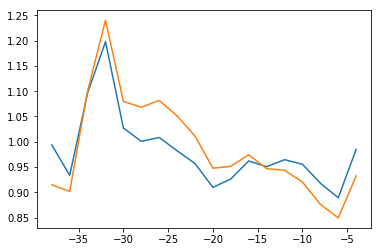

In [7]:
#convert angle-freq to obeserved coordinates

arm = 'trailing'

if arm == 'leading' :
    phi1_min=-60.
    phi1_max=-40. #becuase of numpy.arange
    phi1_prog_bound=-42.
    
else :
    phi1_min=-38.
    phi1_max=-2.  #becuase of numpy.arange
    phi1_prog_bound=-38.
    

with open('pkl_files/pklfiles_3.2Gyr_sigv0.3/gd1_smooth_pepper_{}_Plummer_sigv0.3_td3.2_64sampling_progphi1-40.0_MW2014.pkl'.format(arm),'rb') as savefile:
            sdf_smooth= pickle.load(savefile,encoding='latin1')
            sdf_pepper= pickle.load(savefile,encoding='latin1')


dir = 'dens_Omega/ABC_sims/'+arm+'/'
print (dir)

#load the apars (same apars in all the files) to compute the jacobian d(apar)/d(phi1)
dat= np.loadtxt(dir + "GD1_prog-40.0_sigv0.3_{}_densOmega_3200_on_64_subhalo_GMC_Plummer_Mmin105.0_rand_rotate_batch0_10.dat".format(arm))
apars=dat[:,1]
dens_smooth=dat[:,2]
dens=dat[:,3]
Omega=dat[:,5]
mT= sdf_pepper.meanTrack(apars,_mO=Omega,coord='lb')
phi1=lb_to_phi12(mT[0],mT[1],degree=True)[:,0]
phi1[phi1 > 180.]-=360.

#phi1=np.radians(phi1)

#We want to find d(apar)/d(phi1) at the apars that's in the output file.
#Treating those apars and phi1 as the mid-point of the apar and phi1 bins, compute the 
#their edges. Bin widths are not uniform, so a few more lines of code. For the 
#first and last edge, use the first and last bin width.

apar_edge=[]
phi1_edge=[]

abw0=apars[1]-apars[0]
apar_edge.append(apars[0]-(abw0/2.))

phi1bw0=phi1[1]-phi1[0]
phi1_edge.append(phi1[0]-(phi1bw0/2.))

for ii in range(len(apars)-1):
    abw=apars[ii+1]-apars[ii]
    phi1bw=phi1[ii+1]-phi1[ii]
    apar_edge.append(apars[ii]+abw/2.)
    phi1_edge.append(phi1[ii]+phi1bw/2.)


abw_last=apars[len(apars)-1]-apars[len(apars)-2]
apar_edge.append(apars[len(apars)-1]+(abw_last/2.))

phi1bw_last=phi1[len(phi1)-1]-phi1[len(phi1)-2]
phi1_edge.append(phi1[len(phi1)-1]+(phi1bw_last/2.))

#compute d(apar)/d(phi1) using finite difference method
dapar_dphi1=(numpy.diff(apar_edge)/numpy.diff(phi1_edge))

#Interpolate Jacobian
ipdapar_dphi1=interpolate.InterpolatedUnivariateSpline(phi1,dapar_dphi1)

#Interpolate apar(phi1)
ipphi1= interpolate.InterpolatedUnivariateSpline(phi1,apars)

#Interpolate dens(apar)
ipdens_apar= interpolate.InterpolatedUnivariateSpline(apars,dens)

#Interpolate density(phi1) by multiplying by jacobian
dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1,ipdens_apar(ipphi1(phi1))*ipdapar_dphi1(phi1))

#3rd order polynomial 
ppdens_apar= Polynomial.fit(apars,dens,deg=3)
ppdens_phi1= Polynomial.fit(phi1,dens_phi1(phi1),deg=3)

#phi1 where we want to output 
outphi1= numpy.arange(phi1_min,phi1_max,2.)

#Interpolate dens_apar/poly(dens_apar)
ipdens_apar_cont= interpolate.InterpolatedUnivariateSpline(phi1,dens/ppdens_apar(ipphi1(phi1)))

#Interpolate dens_phi1/poly(dens_phi1)
ipdens_phi1_cont= interpolate.InterpolatedUnivariateSpline(phi1,dens_phi1(phi1)/ppdens_phi1(phi1))


plt.figure()
plt.plot(outphi1,ipdens_apar_cont(outphi1))
plt.plot(outphi1,ipdens_phi1_cont(outphi1))
plt.show()
        

### for each sim, weed out (1) the ones that has buggy tracks, (2) the ones whose density falls below 20% of that around 2 deg near the progenitor. 

In [3]:
def compute_obs_density(phi1,apars,dens_apar,Omega):
    
    apar_edge=[]
    phi1_edge=[]

    abw0=apars[1]-apars[0]
    apar_edge.append(apars[0]-(abw0/2.))

    phi1bw0=phi1[1]-phi1[0]
    phi1_edge.append(phi1[0]-(phi1bw0/2.))

    for ii in range(len(apars)-1):
        abw=apars[ii+1]-apars[ii]
        phi1bw=phi1[ii+1]-phi1[ii]
        apar_edge.append(apars[ii]+abw/2.)
        phi1_edge.append(phi1[ii]+phi1bw/2.)


    abw_last=apars[len(apars)-1]-apars[len(apars)-2]
    apar_edge.append(apars[len(apars)-1]+(abw_last/2.))

    phi1bw_last=phi1[len(phi1)-1]-phi1[len(phi1)-2]
    phi1_edge.append(phi1[len(phi1)-1]+(phi1bw_last/2.))

    #compute the Jacobian d(apar)/d(phi1) using finite difference method
    dapar_dphi1=(numpy.diff(apar_edge)/numpy.diff(phi1_edge))

    #Interpolate Jacobian
    ipdapar_dphi1=interpolate.InterpolatedUnivariateSpline(phi1,dapar_dphi1)
    
    #Interpolate dens(apar)
    ipdens_apar= interpolate.InterpolatedUnivariateSpline(apars,dens)

    #Interpolate apar(phi1)
    if phi1[1] < phi1[0] : # ad-hoc way of checking whether increasing or decreasing
        ipphi1= interpolate.InterpolatedUnivariateSpline(phi1[::-1],apars[::-1])
        
    else :
        ipphi1= interpolate.InterpolatedUnivariateSpline(phi1,apars)
            
    #Interpolate density(phi1) by multiplying by jacobian
    dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1,ipdens_apar(ipphi1(phi1))*ipdapar_dphi1(phi1))
    
    return (dens_phi1(phi1))
    
    

dens_Omega/ABC_sims/trailing/


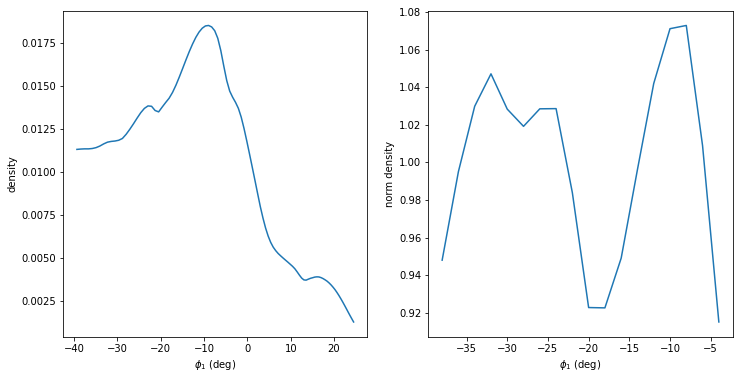

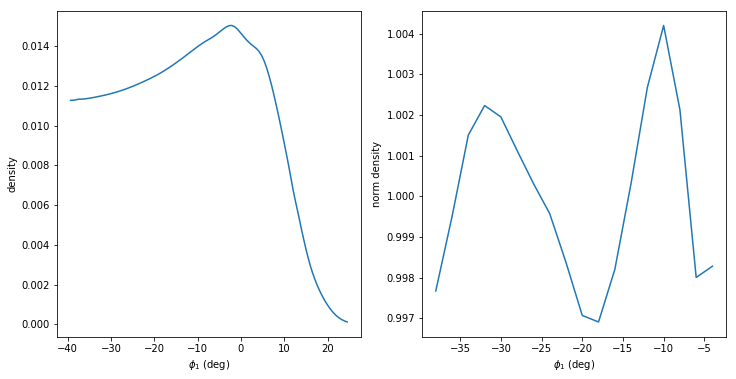

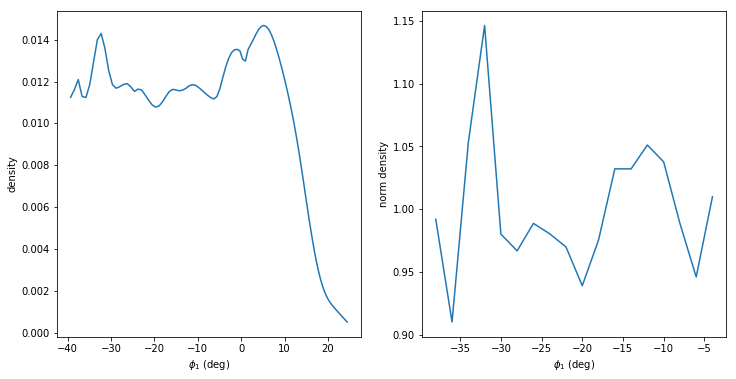

Rejected based on length


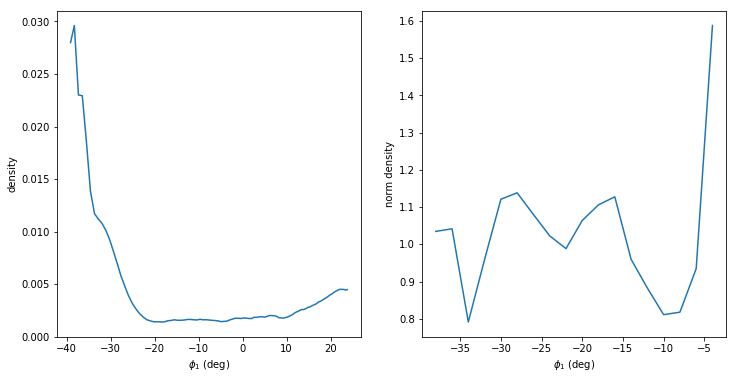

Reject
Rejected based on length


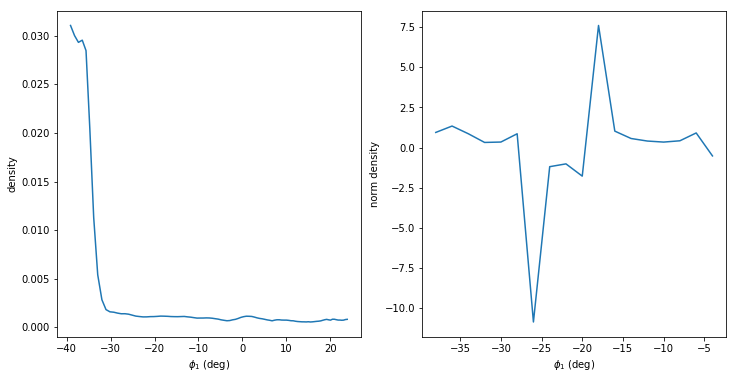

Rejected based on length


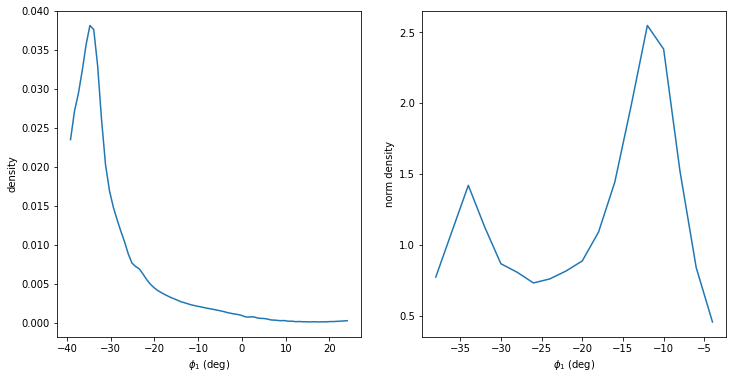

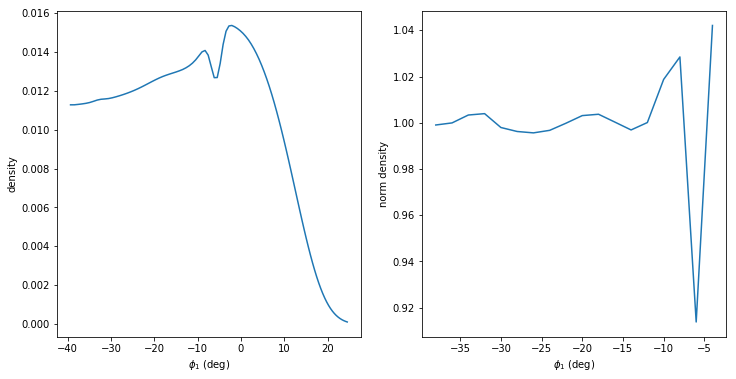

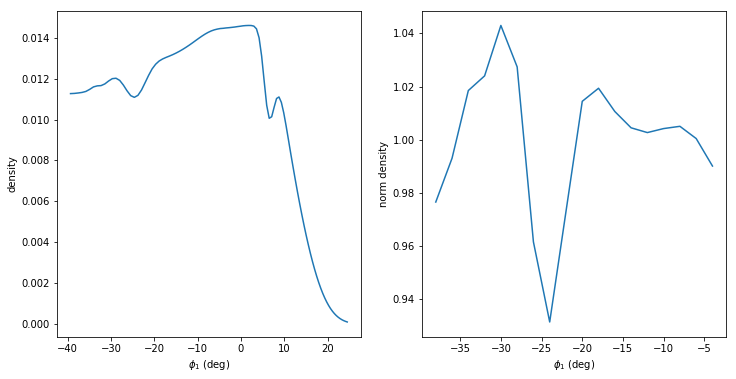

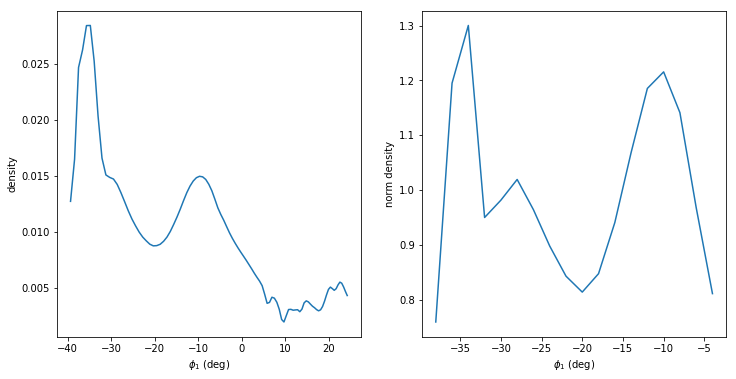

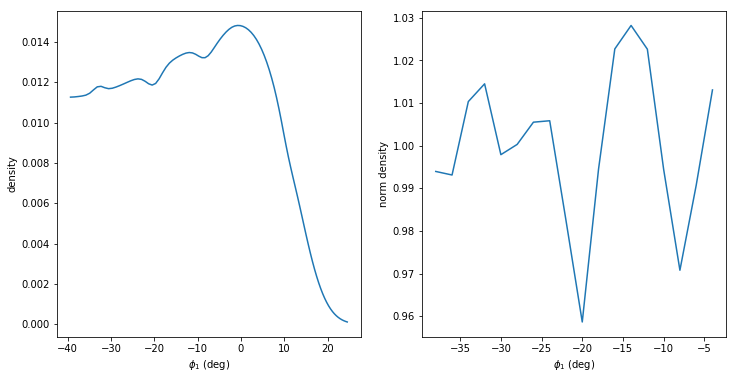

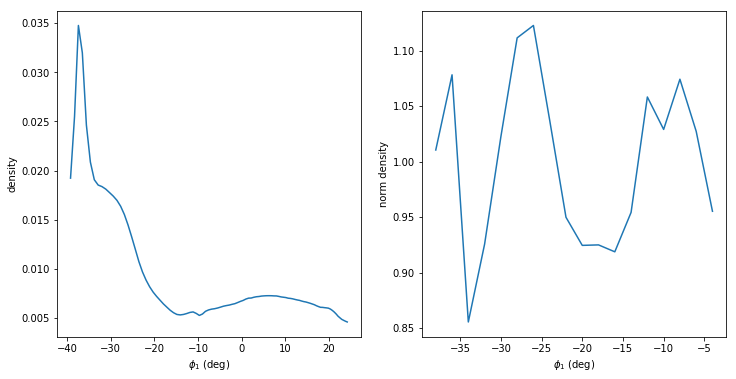

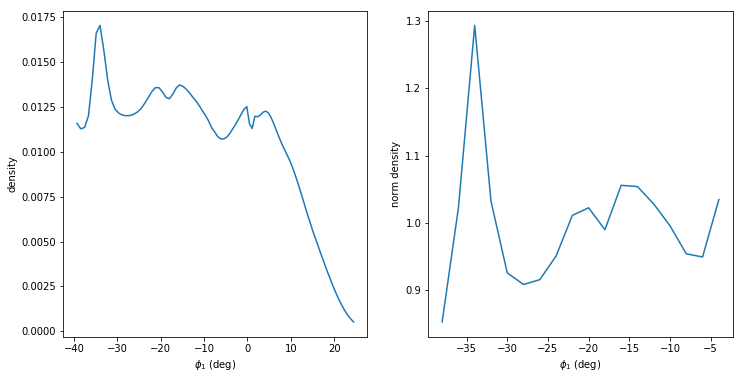

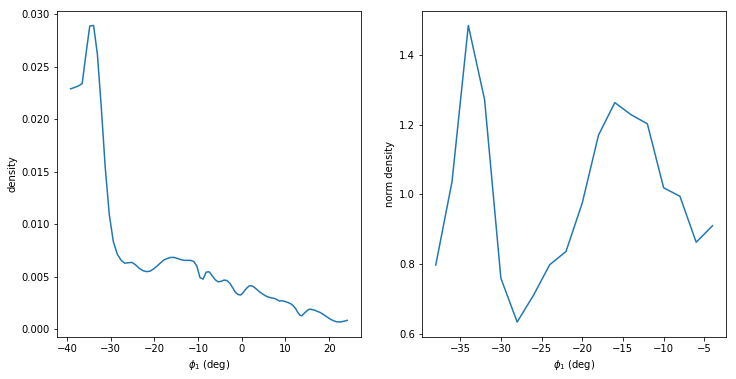

Rejected based on length


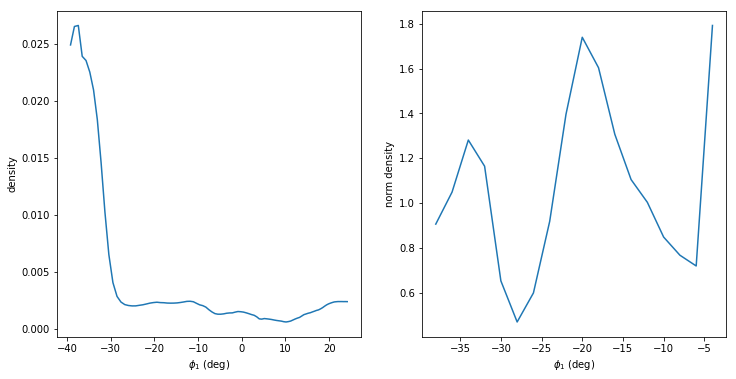

Reject
Rejected based on length


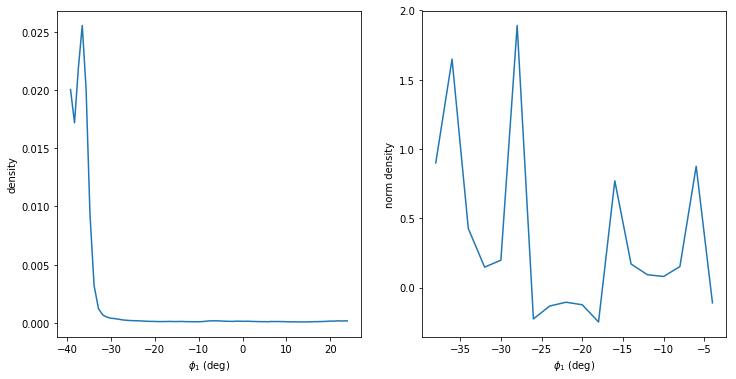

Reject
Rejected based on length


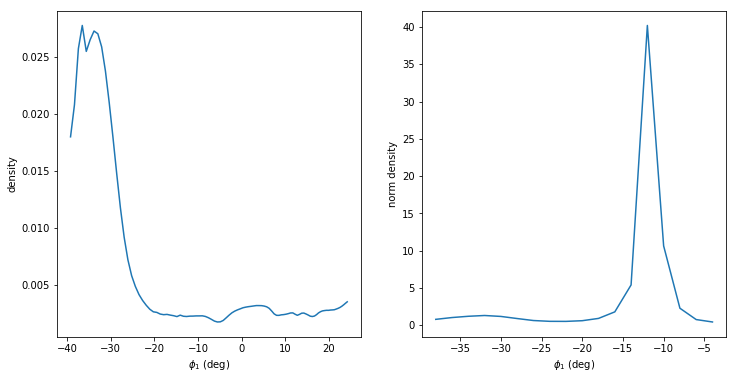

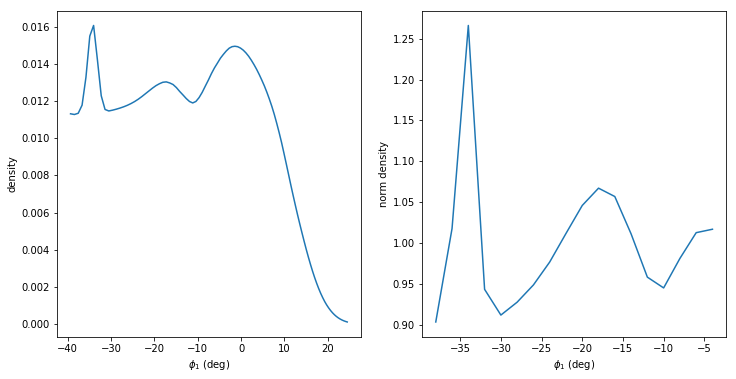

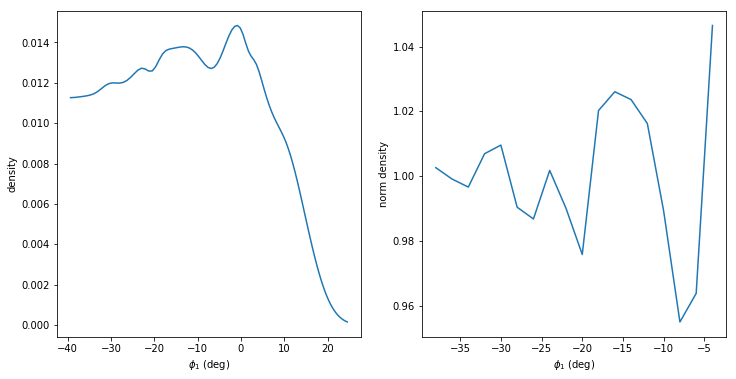

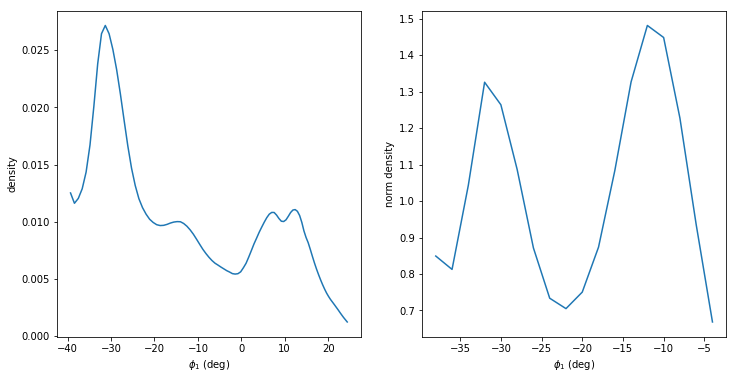

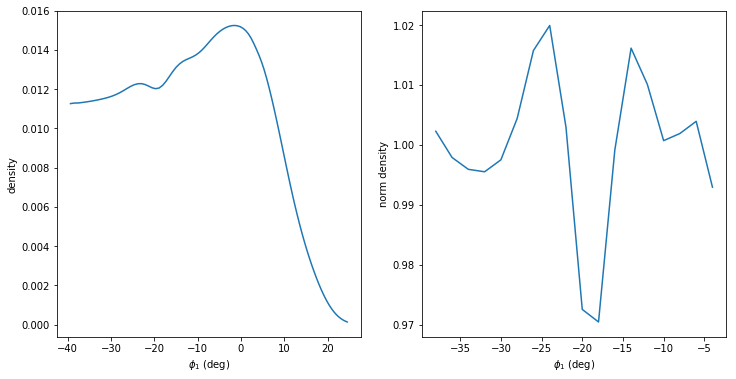

In [6]:
#convert angle-freq to obeserved coordinates

arm = 'trailing'

if arm == 'leading' :
    phi1_min=-60.
    phi1_max=-40. #becuase of numpy.arange
    phi1_prog_bound=-42.
    
else :
    phi1_min=-38.
    phi1_max=-2.  #becuase of numpy.arange
    phi1_prog_bound=-38.
    

with open('pkl_files/pklfiles_3.2Gyr_sigv0.3/gd1_smooth_pepper_{}_Plummer_sigv0.3_td3.2_64sampling_progphi1-40.0_MW2014.pkl'.format(arm),'rb') as savefile:
            sdf_smooth= pickle.load(savefile,encoding='latin1')
            sdf_pepper= pickle.load(savefile,encoding='latin1')


dir = 'dens_Omega/ABC_sims/'+arm+'/'
trash_dir='dens_Omega/trash/'
print (dir)

allfname= glob.glob(dir + '*.dat')[0:20]

for jj in allfname:
    #
    #print (jj)
    #'#apar   dens_unp   dens  omega_unp   omega'
    dat=np.loadtxt(jj)
    l10rate=dat[:,0][0]
    apars=dat[:,1]
    dens_smooth=dat[:,2]
    dens=dat[:,3]
    Omega=dat[:,5]
    fn = jj.replace(dir,'')
    #print (fn)   
    mT= sdf_pepper.meanTrack(apars,_mO=Omega,coord='lb')
    phi1=lb_to_phi12(mT[0],mT[1],degree=True)[:,0]
    phi1[phi1 > 180.]-=360.
    outphi1= numpy.arange(phi1_min,phi1_max,2.)

    try:
        dens_phi1 = compute_obs_density(phi1,apars,dens,Omega)
        ip_dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1,dens_phi1)
        
        #compute polynomial and density at outphi1
        ppdens_phi1= Polynomial.fit(outphi1,ip_dens_phi1(outphi1),deg=3)
        
        dens_cont=ip_dens_phi1(outphi1)/ppdens_phi1(outphi1)
        #print (dens_cont)
        if True in any(x < 0 for x in dens_cont) or True in any(x > 10 for x in dens_cont) :
            print ("Reject")
        
        
        #compute mean density within 2 deg of the progenitor
        if arm == 'leading' :    
            mean_den=np.mean(dens_phi1[(phi1 >= -44.) & (phi1 <= -40.)])
            
        else :    
            mean_den=np.mean(dens_phi1[(phi1 >= -40.) & (phi1 <= -36.)])
        
        #print (mean_den)
        
        if True in any(ip_dens_phi1(x)-0.1*mean_den < 0 for x in outphi1) :
            print ("Rejected based on length")
        
        
        #pp= Polynomial.fit(apar,dens,deg=3)
        #outphi1= numpy.linspace(-60.,-5.,300)
        # Interpolate density
        #ipdens_poly= interpolate.InterpolatedUnivariateSpline(apar,dens/pp(apar))
        #ipdens= interpolate.interp1d(apar,dens/pp(apar),kind='cubic')
        #print (l10rate)
        plt.figure(figsize=(12,6))
        plt.subplot(1,2,1)
        #
        plt.plot(phi1,dens_phi1)
        #plt.vlines(-38.,-0.01,0.03)
        plt.xlabel(r'$\phi_{1}$ (deg)')
        plt.ylabel(r'density')
        
        plt.subplot(1,2,2)
        plt.plot(outphi1,dens_cont)
        plt.xlabel(r'$\phi_{1}$ (deg)')
        plt.ylabel(r'norm density')
        
        #plt.savefig('weird_density{}.pdf'.format(l10rate))
        plt.show()

        #ll,tdata= convert_dens_to_obs(apar,dens,dens_unp,Omega,poly_deg=3)
        '''
        fname = fn.replace('densOmega','phi1{}_{}_polynorm3'.format(min(outphi1),max(outphi1)))
        #print (fname)
        fo=open(dir + 'physical_coords/'+fname,'w')
        fo.write('#phi1   dens/dens_smooth' + '\n')

        for ii in range(len(outphi1)):
            fo.write(str(outphi1[ii]) + '   ' + str(ipdens(ipphi1(outphi1))[ii]) + '\n')

        fo.close()
        '''
    except ValueError as e:
            print (jj)
            print (e)
            os.rename(jj, trash_dir + fn) #move buggy realizations to trash 

In [ ]:
###COPY of the above cell

#convert angle-freq to obeserved coordinates

arm = 'trailing'

if arm == 'leading' :
    phi1_min=-60.
    phi1_max=-40. #becuase of numpy.arange
    phi1_prog_bound=-42.
    
else :
    phi1_min=-38.
    phi1_max=-2.  #becuase of numpy.arange
    phi1_prog_bound=-38.
    

with open('pkl_files/pklfiles_3.2Gyr_sigv0.3/gd1_smooth_pepper_{}_Plummer_sigv0.3_td3.2_64sampling_progphi1-40.0_MW2014.pkl'.format(arm),'rb') as savefile:
            sdf_smooth= pickle.load(savefile,encoding='latin1')
            sdf_pepper= pickle.load(savefile,encoding='latin1')


dir = 'dens_Omega/ABC_sims/'+arm+'/'
trash_dir='dens_Omega/trash/'
print (dir)

allfname= glob.glob(dir + '*.dat')[0:10]

for jj in allfname:
    #
    #print (jj)
    #'#apar   dens_unp   dens  omega_unp   omega'
    dat=np.loadtxt(jj)
    l10rate=dat[:,0][0]
    apar=dat[:,1]
    dens_smooth=dat[:,2]
    dens=dat[:,3]
    Omega=dat[:,5]
    fn = jj.replace(dir,'')
    print (fn)   
    mT= sdf_pepper.meanTrack(apars,_mO=Omega,coord='lb')
    phi1=lb_to_phi12(mT[0],mT[1],degree=True)[:,0]
    phi1[phi1 > 180.]-=360.

    try:
        dens_phi1 = compute_obs_density(phi1,apars,dens,Omega)
        pp= Polynomial.fit(apar,dens,deg=3)
        #outphi1= numpy.linspace(-60.,-5.,300)
        # Interpolate density
        ipdens_poly= interpolate.InterpolatedUnivariateSpline(apar,dens/pp(apar))
        #ipdens= interpolate.interp1d(apar,dens/pp(apar),kind='cubic')
        print (l10rate)
        plt.figure(figsize=(12,6))
        plt.subplot(1,2,1)
        plt.plot(outphi1,ipdens(ipphi1(outphi1)))
        plt.xlabel(r'$\phi_{1}$ (deg)')
        plt.ylabel(r'norm density')
        
        plt.subplot(1,2,2)
        plt.plot(outphi1,ipdens_poly(ipphi1(outphi1)))
        plt.xlabel(r'$\phi_{1}$ (deg)')
        plt.ylabel(r'norm density')
        
        plt.savefig('weird_density{}.pdf'.format(l10rate))
        plt.show()

        #ll,tdata= convert_dens_to_obs(apar,dens,dens_unp,Omega,poly_deg=3)
        
        fname = fn.replace('densOmega','phi1{}_{}_polynorm3'.format(min(outphi1),max(outphi1)))
        #print (fname)
        fo=open(dir + 'physical_coords/'+fname,'w')
        fo.write('#phi1   dens/dens_smooth' + '\n')

        for ii in range(len(outphi1)):
            fo.write(str(outphi1[ii]) + '   ' + str(ipdens(ipphi1(outphi1))[ii]) + '\n')

        fo.close()

    except ValueError as e:
            print (jj)
            print (e)
            os.rename(jj, trash_dir + fn) #move buggy realizations to trash 

In [ ]:
#Interpolate dens(apar)
ipdens_apar= interpolate.InterpolatedUnivariateSpline(apars,dens)

#Interpolate density(phi1) by multiplying by jacobian
dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1,ipdens_apar(ipphi1(phi1))*ipdapar_dphi1(phi1))

#3rd order polynomial 
ppdens_apar= Polynomial.fit(apars,dens,deg=3)
ppdens_phi1= Polynomial.fit(phi1,dens_phi1(phi1),deg=3)

#phi1 where we want to output 
outphi1= np.radians(numpy.arange(phi1_min,phi1_max,2.))

#Interpolate dens_apar/poly(dens_apar)
ipdens_apar_cont= interpolate.InterpolatedUnivariateSpline(phi1,dens/ppdens_apar(ipphi1(phi1)))

#Interpolate dens_phi1/poly(dens_phi1)
ipdens_phi1_cont= interpolate.InterpolatedUnivariateSpline(phi1,dens_phi1(phi1)/ppdens_phi1(phi1))


plt.figure()
plt.plot(outphi1,ipdens_apar_cont(outphi1))
plt.plot(outphi1,ipdens_phi1_cont(outphi1))
plt.show()       
        

In [ ]:
#convert angle-freq to obeserved coordinates

arm = 'trailing'

if arm == 'leading' :
    phi1_min=-60.
    phi1_max=-40. #becuase of numpy.arange
    phi1_prog_bound=-42.
    
else :
    phi1_min=-38.
    phi1_max=-2.  #becuase of numpy.arange
    phi1_prog_bound=-38.
    

with open('pkl_files/pklfiles_3.2Gyr_sigv0.3/gd1_smooth_pepper_{}_Plummer_sigv0.3_td3.2_64sampling_progphi1-40.0_MW2014.pkl'.format(arm),'rb') as savefile:
            sdf_smooth= pickle.load(savefile,encoding='latin1')
            sdf_pepper= pickle.load(savefile,encoding='latin1')

            
dir = 'dens_Omega/ABC_sims/'+arm+'/'

dat=np.loadtxt(dir + "GD1_prog-40.0_sigv0.3_{}_densOmega_3200_on_64_subhalo_GMC_Plummer_Mmin105.0_rand_rotate_batch0_11.dat".format(arm))

#'#apar   dens_unp   dens  omega_unp   omega'
l10rate=dat[:,0][0]
apars=dat[:,1]
dens_smooth=dat[:,2]
dens=dat[:,3]
Omega=dat[:,5]


mT= sdf_pepper.meanTrack(apars,_mO=Omega,coord='lb')
phi1=lb_to_phi12(mT[0],mT[1],degree=True)[:,0]
phi1[phi1 > 180.]-=360.

print (phi1)

In [ ]:
#We want to find d(apar)/d(phi1) at the apars that's in the output file.
#Treating those apars and phi1 as the mid-point of the apar and xi bins, compute the 
#their edges. Bin widths are not uniform, so a few more lines of code. For the 
#first and last edge, use the first and last bin width.

apar_edge=[]
phi1_edge=[]

abw0=apars[1]-apars[0]
apar_edge.append(apars[0]-(abw0/2.))

phi1bw0=phi1[1]-phi1[0]
phi1_edge.append(phi1[0]-(phi1bw0/2.))


for ii in range(len(apars)-1):
    abw=apars[ii+1]-apars[ii]
    phi1bw=phi1[ii+1]-phi1[ii]
    apar_edge.append(apars[ii]+abw/2.)
    phi1_edge.append(phi1[ii]+phi1bw/2.)


abw_last=apars[len(apars)-1]-apars[len(apars)-2]
apar_edge.append(apars[len(apars)-1]+(abw_last/2.))

phi1bw_last=phi1[len(phi1)-1]-phi1[len(phi1)-2]
phi1_edge.append(phi1[len(phi1)-1]+(phi1bw_last/2.))

print (apars,apar_edge)

In [ ]:
#compute d(apar)/d(phi1) using finite difference method
dapar_dphi1=(numpy.diff(apar_edge)/numpy.diff(phi1_edge))

#Interpolate Jacobian
ipdapar_dphi1=interpolate.InterpolatedUnivariateSpline(phi1,dapar_dphi1)
outphi1= numpy.arange(phi1_min,phi1_max,2.) 
#print (ipdapar_dphi1(outphi1))

# Interpolate phi1 and apar
ipphi1= interpolate.InterpolatedUnivariateSpline(phi1,apars)
ipdens_apar= interpolate.InterpolatedUnivariateSpline(apars,dens) #note only dens
dens_phi1=ipdens_apar(ipphi1(outphi1))*ipdapar_dphi1(outphi1)
pp= Polynomial.fit(outphi1,dens_phi1,deg=3)

print (ipdens_apar(apars))

print (dens_phi1)

print (ipdens_apar(ipphi1(outphi1)))
pp_nojac= Polynomial.fit(apars,dens,deg=3)

plt.figure()
plt.plot(outphi1,dens_phi1)
plt.plot(outphi1,ipdens_apar(ipphi1(outphi1))/pp_nojac(ipphi1(outphi1)))
#plt.plot(outphi1,dens_phi1)
plt.show()

In [ ]:


#dens(phi1) = dens(apars)*d(apar)/d(phi1)


ipdens_smooth_apar= interpolate.InterpolatedUnivariateSpline(apars,dens_smooth)


dens_smooth_phi1=ipdens_smooth_apar(ipphi1(outphi1))*ipdapar_dphi1(outphi1)
pp_nojac= Polynomial.fit(apars,dens,deg=3)
pp= Polynomial.fit(outphi1,dens_phi1,deg=poly_deg)

return (outphi1,dens_phi1,dens_smooth_phi1,pp(outphi1),pp_nojac(outphi1))
    

In [ ]:
#convert angle-freq to obeserved coordinates

arm = 'trailing'

if arm == 'leading' :
    phi1_min=-60.
    phi1_max=-40. #becuase of numpy.arange
    phi1_prog_bound=-42.
    
else :
    phi1_min=-38.
    phi1_max=-2.  #becuase of numpy.arange
    phi1_prog_bound=-38.
    

with open('pkl_files/pklfiles_3.2Gyr_sigv0.3/gd1_smooth_pepper_{}_Plummer_sigv0.3_td3.2_64sampling_progphi1-40.0_MW2014.pkl'.format(arm),'rb') as savefile:
            sdf_smooth= pickle.load(savefile,encoding='latin1')
            sdf_pepper= pickle.load(savefile,encoding='latin1')

            
dir = 'dens_Omega/ABC_sims/'+arm+'/'
print (dir)

trash_dir='dens_Omega/trash/'

allfname= glob.glob(dir + '*.dat')[0:2]

for jj in allfname:
    
    print (jj)
    #'#apar   dens_unp   dens  omega_unp   omega'
    dat=np.loadtxt(jj)
    l10rate=dat[:,0][0]
    apar=dat[:,1]
    dens_smooth=dat[:,2]
    dens=dat[:,3]
    Omega=dat[:,5]
    fn = jj.replace(dir,'')
    p1,dens_p1,dens_sm_p1,pp_jac,pp_nojac= convert_dens_apar_to_dens_phi1(sdf_pepper,apar,dens,dens_smooth,Omega,phi1_min,phi1_max)
    
    plt.figure()
    plt.plot(p1,dens_p1/pp_jac,c='r')
    plt.plot(p1,pp_nojac,c='b')
    plt.show()
        